In [1]:
import numpy as np
from scipy.linalg import null_space
from scipy.linalg import ishermitian
from scipy.linalg import issymmetric
from scipy.linalg import eigh
from scipy.linalg import norm
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.linalg import eig
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.linalg import svd

import networkx as nx
import matplotlib.pyplot as plt

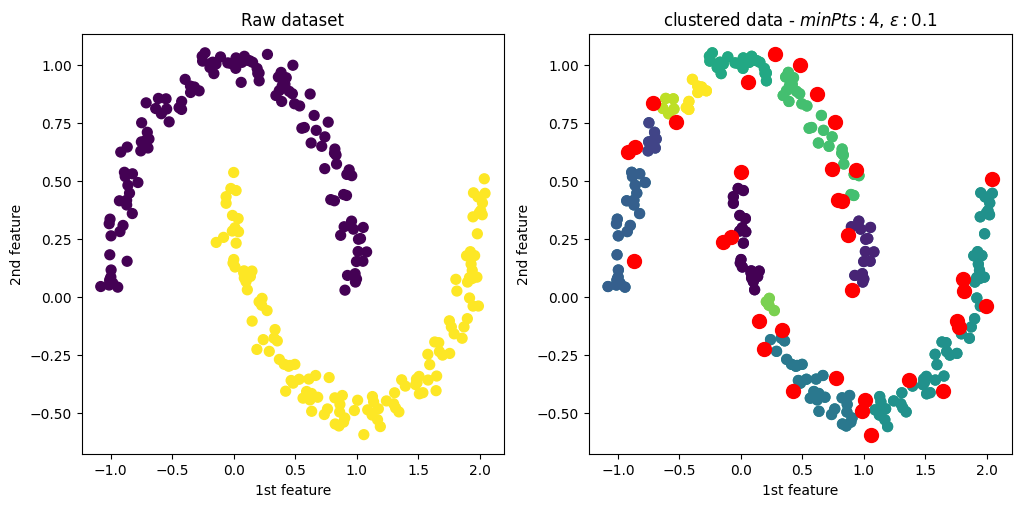

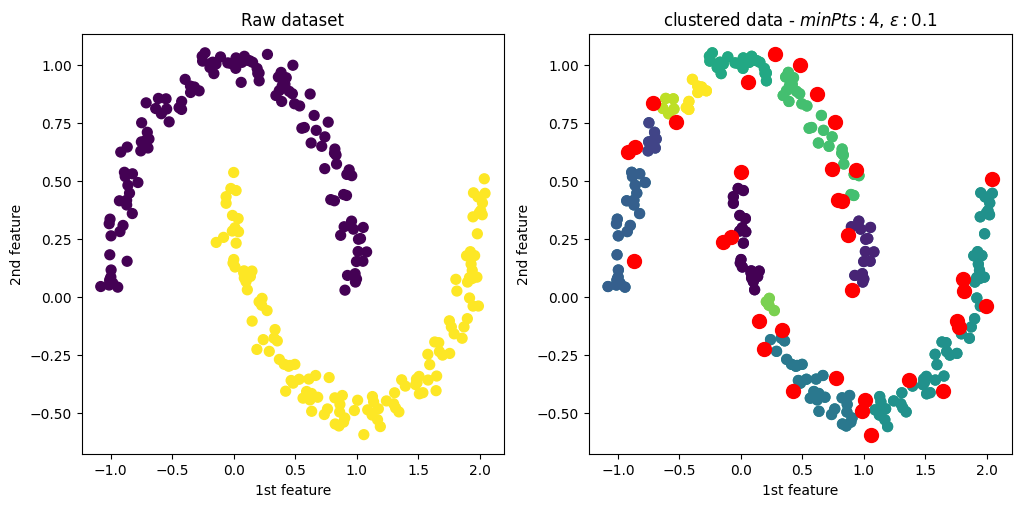

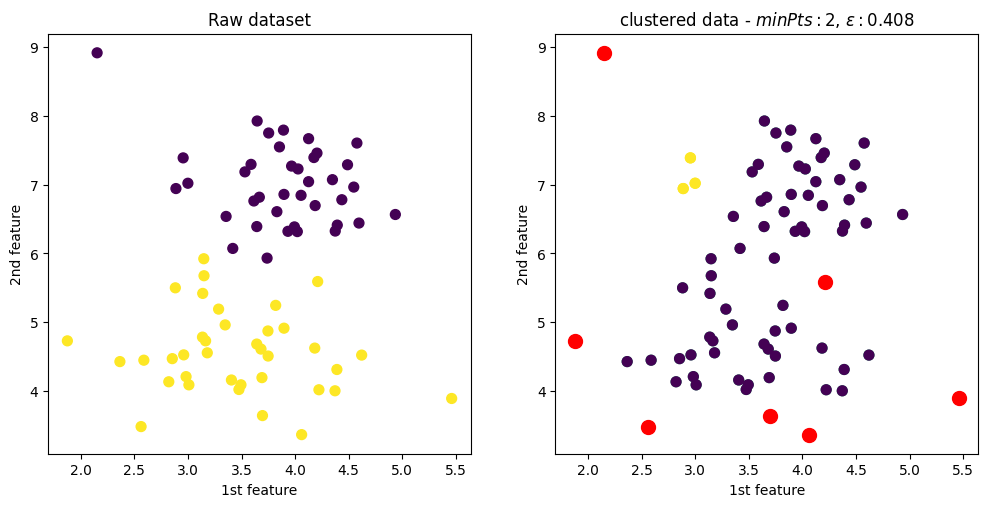

number of lambdas:  8


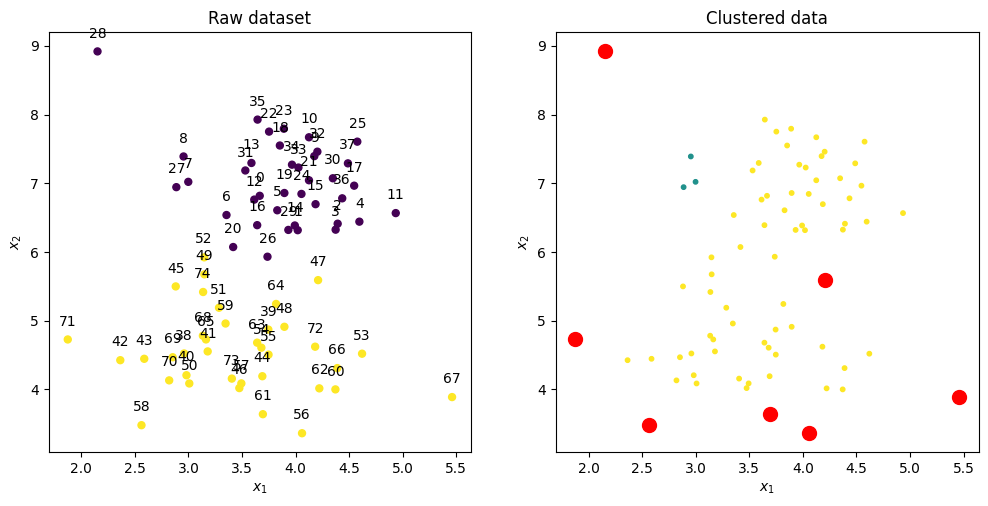

In [2]:
# running necessary functions
%run tree_plotting.ipynb
%run distance_metric.ipynb
%run density_tree.ipynb
%run DBSCAN.ipynb
%run SpectralClustering.ipynb

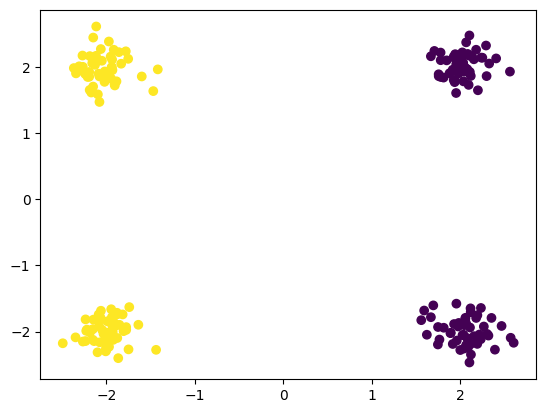

In [37]:
# generating dataset with binary sensitive attribute

# Generate random data for each cluster
cluster1 = np.random.normal(loc=[2, 2], scale=0.2, size=(50, 2))  # might need to make loc smaller for eps
cluster2 = np.random.normal(loc=[2, -2], scale=0.2, size=(50, 2))
cluster3 = np.random.normal(loc=[-2, -2], scale=0.2, size=(50, 2))
cluster4 = np.random.normal(loc=[-2, 2], scale=0.2, size=(50, 2))

# Create a binary-sensitive attribute
sensitive = np.concatenate((np.zeros(100), np.ones(100)))

# Combine data and shuffle
data = np.concatenate((cluster1, cluster2, cluster3, cluster4))
data_sensitive = np.concatenate((data, sensitive.reshape(-1, 1)), axis=1)

plt.scatter(data_sensitive[:, 0], data_sensitive[:, 1], c=data_sensitive[:, 2])
plt.show()

In [38]:
# imposing fairness constraint
def unnormalized_SC_With_Fairness_Constraints(W, k, sensitive, laplacian = True):
    '''
    implementation of fair unnormalized SC with fairness constraints (algorithm 2) translated from MATLAB
    to Python
    
    github repo with original matlab code from paper: https://github.com/matthklein/fair_spectral_clustering/blob/master/Fair_SC_unnormalized.m
    
    # input: W weighted adjacency matrix (nxn), k number of clusters, sensitive encoding the sensitive attribute
    
    # output: H - eigenvectors drawn out of the subspace
    '''
    
    ####### COMPUTING L
    if laplacian == True:
        # compute degree matrix
        degrees = np.sum(W, axis=1)
        D = np.diag(degrees)

        # compute Laplacian from D and W (nxn)
        L = D-W
    else:
        L = W
    ######## COMPUTING L
    
    
    ######## COMPUTING F
    n = W.shape[0]
    sens_unique = np.unique(sensitive)
    h = len(sens_unique)
    sens_unique = np.reshape(sens_unique, [1,h])
    
    # sensitiveNew = sensitive.copy()  # should be npzeros
    sensitiveNEW = np.zeros(n)
    # print(n)
    
    temp = 0
    # print(len(sensitive))
    # print(len(sensitiveNEW))
    for i in range(h):
        for j in range(len(sensitive)):
            if sens_unique[0][i] == sensitive[j]:
                sensitiveNEW[j] = temp
        temp += 1
        
    # print(sensitiveNEW)
    
    # F - encodes group membership info from sensitiveNEW
    # normalize F so each 
    F = np.zeros((n, h-1)) # checkup with starting indices - F must be the issue
    for i in range(h-1):
        temp = (sensitiveNEW == i + 1)  # arrays start at 0, so need to add for boolean mask
        # print("temp: ", temp)
        F[temp, i] = 1
        groupSize = np.sum(temp)
        # print("gS \n", groupSize)
        F[:, i] = F[:, i] - (groupSize/n)  # operation that enforces balance constraint  # does it need to be i-1? 
    

    # the group membership vector sensitiveNEW - sensitivegroup/n multiplied with 1-vector
    
    
    # normalize
    F = F / np.linalg.norm(F, axis=0)
    # print("normal \n", F)
    ########### COMPUTING F
    
    ########## COMPUTING Z
    
#     Z = null_space(F.T)
#     Z = Z / np.linalg.norm(Z, axis=0)  # normalized for orthonormal basis
    
    # computing with equivalency to MATLAB's null function
    U, S, V = svd(F.T)
    
    # checking dimensions and finding rank
    m, n = (F.T).shape
    rank = np.sum(S > np.finfo(float).eps * max(m, n))
    print("rank: ", rank)
    
    # extract columns of V that are singular values close to zero
    null_space = V[rank:].T
    
    # normalize columns of null_space
    null_space = null_space / np.linalg.norm(null_space, axis = 0)
    Z = null_space  # equivalency to scipy's norm function, no issue there
    
    
    
    ########### COMPUTING Z
    
    ########## COMPUTING eigenvectors and H
    print(Z.shape)
    print((L@Z).shape)
    print(L.shape)
    
    Z_lap = Z.T @ L @ Z
    print(Z_lap.shape)
    Z_lap = (Z_lap + Z_lap.T)/2 # ensuring symmetry
    
    eigValues, Y = eigh(Z_lap)
    # indices = eigValues.argsort()[:k]
    # using first cut
    Y = Y[:, :k]
    
    
    ########### COMPUTING eigenvectors and H
    
    ########## PERFORMING KMEANS
    
    Z_lap = Z.T @ L @ Z
    Z_lap = (Z_lap + Z_lap.T)/2 # ensuring symmetry
    
    # eigValues, Y = eig(Z_lap)
    # indices = eigValues.argsort()[:k]
    try:
        eigValues, Y = eigsh(Z_lap, k, which='SM', maxiter=500, ncv=min(Z_lap.shape[0], max(2*k, 25)))
    except:
        eigValues, Y = eigsh(Z_lap, k, which='SR', maxiter=1000, ncv=min(Z_lap.shape[0], max(2*k, 25)))
    Y = Y[:, :k]
    
    # normalize rows or no?
    # norms = np.linalg.norm(Y, axis=1)
    # Y = Y / np.reshape(norms, (-1, 1))
    
    H = Z @ Y
    
    ########### PERFORMING KMEANS
    
    ########### PERFORMING KMEANS
    
    
    ######### PERFORMING DBSCAN/KMEANS
    kmeans = KMeans(n_clusters=k, random_state=0).fit(H)
    labels = kmeans.labels_
    
    # dbscan = DBSCAN(eps = eps, min_pts = minPts, cluster_type = 'standard')
    # dbscan.fit(X)
    # labels = dbscan.labels_
    # print(y.shape)
    # dbscan.plot2D(y)
    
    return H, labels
    
    ########## DBSCAN
    

    
    # return pseudo
    

In [39]:
from scipy.spatial.distance import pdist, squareform

# Compute pairwise distances
distances = squareform(pdist(data_sensitive[:, :-1]))
# Compute similarity matrix using Gaussian kernel
sigma = 0.5  # parameter for Gaussian kernel
similarity = np.exp(-distances ** 2 / (2 * sigma ** 2))

# Construct weighted adjacency matrix
n = len(data_sensitive)
adjacency = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        w = similarity[i, j]
        adjacency[i, j] = w
        adjacency[j, i] = w
print(adjacency.shape)

(200, 200)


In [40]:
H_sens, labels_sens = unnormalized_SC_With_Fairness_Constraints(adjacency, 2, sensitive, laplacian = True)

rank:  1
(200, 199)
(200, 199)
(200, 200)
(199, 199)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(array([0, 1]), array([100, 100], dtype=int64))


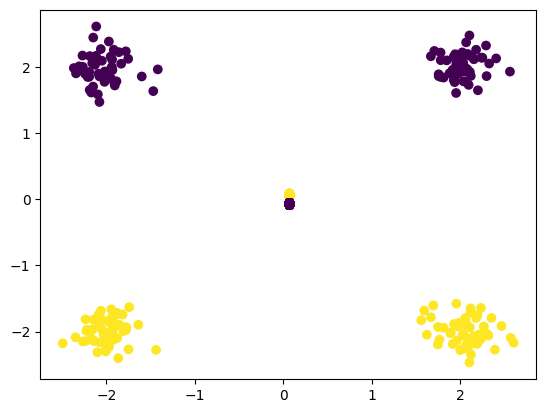

In [43]:
print(labels_sens)
print(np.unique(labels_sens, return_counts = True))
plt.scatter(H_sens[:, 0], H_sens[:, 1], c = labels_sens)
plt.scatter(data[:, 0], data[:, 1], c=labels_sens)
plt.show()

In [44]:
# computing adj with sensitive attributes
# the issue was, the adjacency matrix didn't have the sensitive information encoded it, you never included it!
from sklearn.metrics.pairwise import euclidean_distances

# Compute the pairwise distances
dists = euclidean_distances(data_sensitive[:, :-1])

# Set the threshold epsilon
epsilon = 0.5
                
n = len(data_sensitive)
adj2 = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        w = similarity[i, j]
        adj2[i, j] = w
        adj2[j, i] = w

# Normalize the adjacency matrix
D = np.diag(np.sum(adj2, axis=1))
D_inv = np.linalg.inv(D)
adj_matrix_norm = np.matmul(D_inv, adj2)

# Print the adjacency matrix
# print(adj_matrix_norm.shape)

In [45]:
H_sens2, labels_sens2 = unnormalized_SC_With_Fairness_Constraints(adj_matrix_norm, 2, sensitive, laplacian = True)

rank:  1
(200, 199)
(200, 199)
(200, 200)
(199, 199)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(array([0, 1]), array([100, 100], dtype=int64))


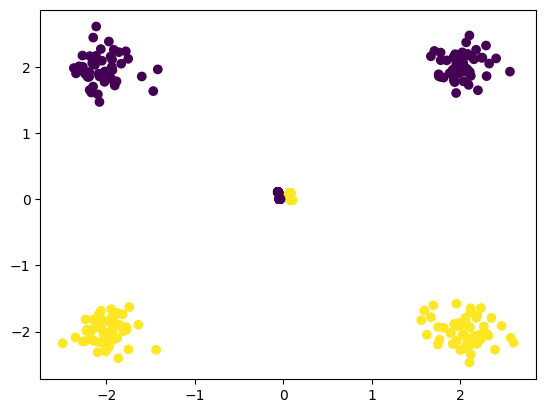

In [48]:
print(labels_sens2)
print(np.unique(labels_sens2, return_counts = True))
plt.scatter(H_sens2[:, 0], H_sens2[:, 1], c = labels_sens2)
plt.scatter(data[:, 0], data[:, 1], c=labels_sens2)
plt.show()